In [1]:
#!pip install lightgbm

In [2]:
#!pip install imbalanced-learn

#!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

##### Plan of action

1. fill null education with most frequent
2. fill null previous_year_rating with 0, as length of service is 1 for all
3. binning age, length_of_service, avg_training_score
4. delete awards won?
5. convert columns to normal?
6. balanced sampling?

In [4]:
df = pd.read_csv('train_LZdllcl.csv')
df.sample(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
27170,1772,Operations,region_2,Bachelor's,m,other,1,33,3.0,6,1,0,59,0
50877,59935,Procurement,region_2,Bachelor's,f,other,1,38,3.0,11,1,0,68,0


In [5]:
df.drop(columns=['employee_id', 'region', 'awards_won?'], axis=1, inplace=True)

In [6]:
df.is_promoted.value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [7]:
50140/4668

10.741216795201371

### Exploratory Data Analysis

<AxesSubplot:>

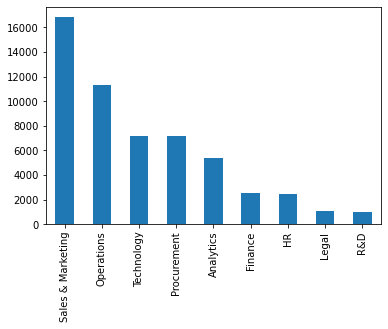

In [8]:
df.department.value_counts().plot(kind='bar')

<AxesSubplot:>

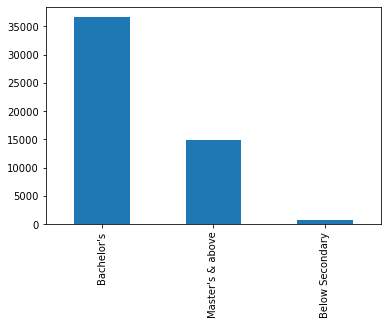

In [9]:
df.education.value_counts().plot(kind='bar')

<AxesSubplot:>

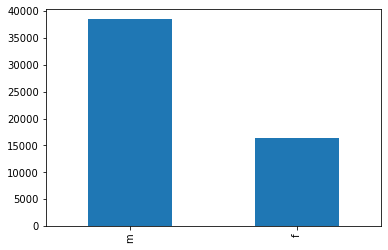

In [10]:
df.gender.value_counts().plot(kind='bar')

<AxesSubplot:>

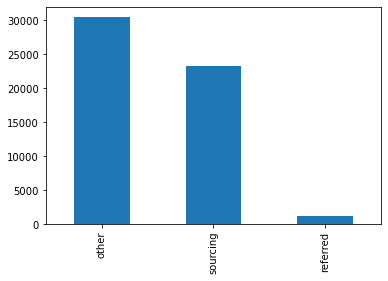

In [11]:
df.recruitment_channel.value_counts().plot(kind='bar')

<AxesSubplot:>

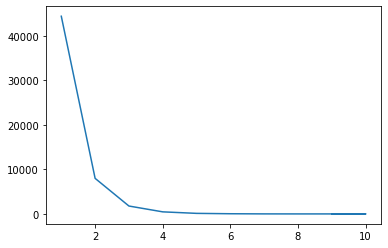

In [12]:
df.no_of_trainings.value_counts().plot()

<AxesSubplot:xlabel='age', ylabel='Density'>

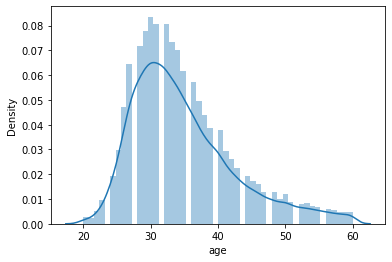

In [13]:
sns.distplot(df.age)

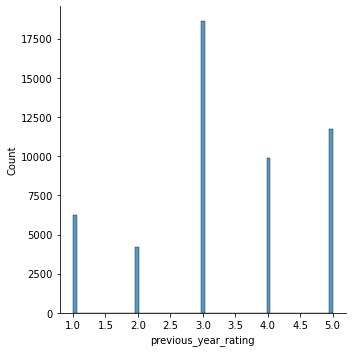

In [14]:
sns.displot(df.previous_year_rating)

<AxesSubplot:xlabel='length_of_service', ylabel='Count'>

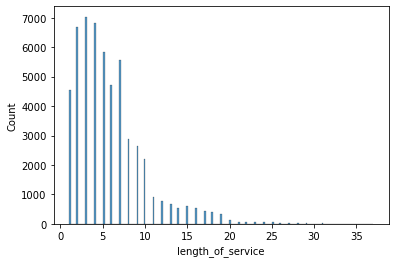

In [15]:
sns.histplot(df.length_of_service)

<AxesSubplot:>

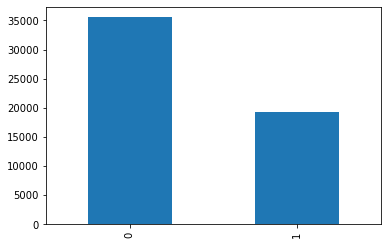

In [16]:
df['KPIs_met >80%'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='avg_training_score', ylabel='Density'>

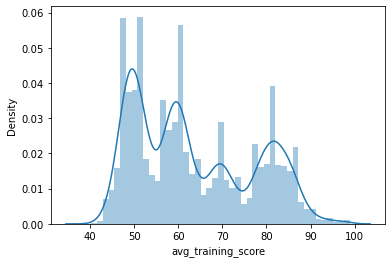

In [17]:
sns.distplot(df.avg_training_score)

<AxesSubplot:>

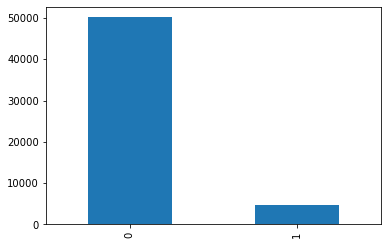

In [18]:
df.is_promoted.value_counts().plot(kind='bar')

In [19]:
df[df.previous_year_rating.isnull()].length_of_service.value_counts()

1    4124
Name: length_of_service, dtype: int64

### Train test split

In [20]:
x = df.iloc[:,0:-1]
y = df.iloc[:, -1]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)


(43846, 10) (10962, 10)


In [22]:
X_train.head(2)

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,avg_training_score
3872,Sales & Marketing,Bachelor's,m,other,1,31,5.0,5,1,48
11619,Technology,Master's & above,m,sourcing,1,34,1.0,4,0,78


### Feature Engineering

In [23]:
trf1 = ColumnTransformer([
    ('imp_edu', SimpleImputer(strategy='most_frequent'), [1]),
    ('imp_pyr', SimpleImputer(strategy='constant', fill_value=0.0), [6])
], remainder='passthrough')

In [24]:
X_train_trf1 = trf1.fit_transform(X_train)

In [25]:
X_train_trf1[0]

array(["Bachelor's", 5.0, 'Sales & Marketing', 'm', 'other', 1, 31, 5, 1,
       48], dtype=object)

In [26]:
trf2 = ColumnTransformer([
    ('binning_a_l_av', KBinsDiscretizer(n_bins=5, strategy='uniform', encode='ordinal'), [6,7,9])
], remainder='passthrough') 

In [27]:
X_train_trf2 = trf2.fit_transform(X_train_trf1)

X_train_trf2[0]

array([1.0, 0.0, 0.0, "Bachelor's", 5.0, 'Sales & Marketing', 'm',
       'other', 1, 1], dtype=object)

In [28]:
trf3 = ColumnTransformer([
    ('ohe_d_g_r', OneHotEncoder(sparse=False, handle_unknown='ignore'), [5,6,7]),
    ('orde_edu', OrdinalEncoder(categories=[['Below Secondary', "Bachelor's", "Master's & above"]]), [3])
], remainder='passthrough')

In [29]:
trf4 = ColumnTransformer([
    ('robustscaler', RobustScaler(), slice(0,10))
], remainder='passthrough')

In [32]:
pipe = Pipeline([
    
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3),
    ('trf4', trf4)
])

In [36]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [55]:
classifiers = {
    #'xgb': XGBClassifier(objective='binary:logistic')
    'lgbm' : LGBMClassifier()
}

parameters = {'xgb':{
                  'max_depth': range (2, 10, 1),
                  'n_estimators': range(60, 220, 40),
                  'learning_rate': [0.1, 0.01, 0.05]
              },
              'lgbm':{
                  'boosting_type' : ['gbdt','dart','goss'],
                  'num_leaves': [300],
                  'max_depth': [5],
                  'learning_rate': [0.01, 0.05, 0.1, 0.3],
                  'n_estimators': [500],
                  'scale_pos_weight' : [3.2]
                  
              }
}


for name,clf in classifiers.items():
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=parameters.get(name),
        scoring = 'f1',
        n_jobs = 10,
        cv = 5,
        verbose=True)

    grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [56]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 300, 'scale_pos_weight': 3.2}
0.4232956621055449


In [57]:
model = LGBMClassifier(boosting_type='dart',
                      learning_rate=0.1,
                      max_depth=5,
                      n_estimators=500,
                      num_leaves=300,
                      scale_pos_weight=3.2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.4116094986807388


In [58]:
a = pd.DataFrame({'Actual_label':y_test, 'Predicted_label': y_pred})
a[a.Actual_label == 1]

,Actual_label,Predicted_label
20735,1,1
35125,1,0
29976,1,1
18668,1,0
47278,1,1
...,...,...
38611,1,1
45834,1,0
8376,1,1
37896,1,1


In [59]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [60]:
p = precision_score(y_test, y_pred)
r = recall_score(y_test, y_pred)

print(p, r)

0.5131578947368421 0.3436123348017621


In [61]:
cm = confusion_matrix(y_test, y_pred)

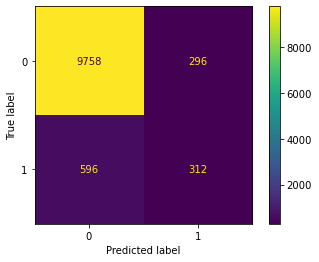

In [62]:
ConfusionMatrixDisplay(cm).plot()

In [71]:
# working on the test data

df_test = pd.read_csv('test_2umaH9m.csv')

In [72]:
df_test.shape

(23490, 13)

In [75]:
df_test_emp_id = df_test['employee_id']
df_test.drop(columns=['employee_id', 'region', 'awards_won?'], axis=1, inplace=True)

In [78]:
df_test = pipe.transform(df_test)

In [79]:
predictions = model.predict(df_test)

In [80]:
predictions

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [91]:
final = pd.concat([df_test_emp_id,pd.Series(predictions)], axis=1)
final.columns = ['employee_id','is_promoted']

In [95]:
final.set_index('employee_id', inplace=True)

In [97]:
final.to_csv('final_submission.csv')